# Installing Packages

In [1]:
!pip install albumentations==0.4.5

     |████████████████████████████████| 122kB 8.3MB/s 
     |████████████████████████████████| 634kB 14.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=61c2493f0dfffce115188664546676eb8fb53235be65db73f9dd5b9f9ea5cbdb
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=82bbcdc4e715743ecd74fb66a5628be6b7a28eedeb9f7993fe20bdc96bb678ca
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Imports
Importing necessary packages and modules

In [0]:
%matplotlib inline

import random

from torchsummary import summary

from cuda import initialize_cuda
from data.dataset import CIFAR10
from model import ResNet18
from model.utils.loss import cross_entropy_loss
from model.utils.optimizers import sgd_optimizer
from model.utils.callbacks import lr_scheduler
from gradcam import GradCAMView
from train import train
from evaluate import val
from result import plot_metric, save_and_show_result

# Configuration

Set various parameters and hyperparameters

In [0]:
class Args:

    # Data Loading
    # ============

    train_batch_size = 64
    val_batch_size = 64
    num_workers = 4

    # Augmentation
    # ============
    horizontal_flip_prob = 0.2
    vertical_flip_prob = 0.0
    gaussian_blur_prob = 0.0
    rotate_degree = 20
    cutout = 0.3

    # Training
    # ========
    random_seed = 1
    epochs = 50
    learning_rate = 0.01
    momentum = 0.9
    lr_step_size = 25
    lr_gamma = 0.1

    # Evaluation
    # ==========
    sample_count = 25

## Set Seed and Get GPU Availability

In [4]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(Args.random_seed)

GPU Available? True


## Download Dataset

Importing the CIFAR-10 class to download dataset and create data loader

In [5]:
dataset = CIFAR10(
    train_batch_size=Args.train_batch_size,
    val_batch_size=Args.val_batch_size,
    cuda=cuda,
    num_workers=Args.num_workers,
    horizontal_flip_prob=Args.horizontal_flip_prob,
    vertical_flip_prob=Args.vertical_flip_prob,
    gaussian_blur_prob=Args.gaussian_blur_prob,
    rotate_degree=Args.rotate_degree,
    cutout=Args.cutout
)

Extracting /content/data/cifar10/cifar-10-python.tar.gz to /content/data/cifar10
Files already downloaded and verified
Files already downloaded and verified


## Training and Validation Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [0]:
# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

# Model Architecture and Summary

In [7]:
model = ResNet18().to(device)  # Create model
summary(model, dataset.image_size)  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Model Training and Validation

In [8]:
losses = []
accuracies = []
correct_samples = []
incorrect_samples = []

criterion = cross_entropy_loss()  # Create loss function
optimizer = sgd_optimizer(model, Args.learning_rate, Args.momentum)  # Create optimizer
scheduler = lr_scheduler(optimizer, Args.lr_step_size, Args.lr_gamma)
last_epoch = False

for epoch in range(1, Args.epochs + 1):
    print(f'Epoch {epoch}:')
    if epoch == Args.epochs:
        last_epoch = True
    train(model, train_loader, device, optimizer, criterion)
    scheduler.step()
    val(
        model, val_loader, device, criterion, losses, accuracies,
        correct_samples, incorrect_samples, Args.sample_count, last_epoch=last_epoch
    )

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0156, Accuracy: 6359/10000 (63.59%)

Epoch 2:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0133, Accuracy: 7053/10000 (70.53%)

Epoch 3:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0106, Accuracy: 7679/10000 (76.79%)

Epoch 4:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0099, Accuracy: 7880/10000 (78.80%)

Epoch 5:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0083, Accuracy: 8180/10000 (81.80%)

Epoch 6:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0079, Accuracy: 8373/10000 (83.73%)

Epoch 7:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0078, Accuracy: 8347/10000 (83.47%)

Epoch 8:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0074, Accuracy: 8444/10000 (84.44%)

Epoch 9:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0069, Accuracy: 8585/10000 (85.85%)

Epoch 10:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0066, Accuracy: 8621/10000 (86.21%)

Epoch 11:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0066, Accuracy: 8669/10000 (86.69%)

Epoch 12:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0073, Accuracy: 8572/10000 (85.72%)

Epoch 13:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0073, Accuracy: 8590/10000 (85.90%)

Epoch 14:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0067, Accuracy: 8708/10000 (87.08%)

Epoch 15:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0067, Accuracy: 8713/10000 (87.13%)

Epoch 16:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0068, Accuracy: 8708/10000 (87.08%)

Epoch 17:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8807/10000 (88.07%)

Epoch 18:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8836/10000 (88.36%)

Epoch 19:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0066, Accuracy: 8792/10000 (87.92%)

Epoch 20:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0062, Accuracy: 8854/10000 (88.54%)

Epoch 21:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0059, Accuracy: 8921/10000 (89.21%)

Epoch 22:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0072, Accuracy: 8688/10000 (86.88%)

Epoch 23:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0059, Accuracy: 8929/10000 (89.29%)

Epoch 24:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0062, Accuracy: 8912/10000 (89.12%)

Epoch 25:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8901/10000 (89.01%)

Epoch 26:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0051, Accuracy: 9065/10000 (90.65%)

Epoch 27:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9104/10000 (91.04%)

Epoch 28:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9100/10000 (91.00%)

Epoch 29:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9117/10000 (91.17%)

Epoch 30:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0051, Accuracy: 9109/10000 (91.09%)

Epoch 31:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9125/10000 (91.25%)

Epoch 32:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9124/10000 (91.24%)

Epoch 33:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9137/10000 (91.37%)

Epoch 34:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0048, Accuracy: 9141/10000 (91.41%)

Epoch 35:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9142/10000 (91.42%)

Epoch 36:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9135/10000 (91.35%)

Epoch 37:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9145/10000 (91.45%)

Epoch 38:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9142/10000 (91.42%)

Epoch 39:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9140/10000 (91.40%)

Epoch 40:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9152/10000 (91.52%)

Epoch 41:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9136/10000 (91.36%)

Epoch 42:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 9170/10000 (91.70%)

Epoch 43:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9147/10000 (91.47%)

Epoch 44:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9153/10000 (91.53%)

Epoch 45:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0051, Accuracy: 9143/10000 (91.43%)

Epoch 46:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9143/10000 (91.43%)

Epoch 47:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9150/10000 (91.50%)

Epoch 48:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0050, Accuracy: 9148/10000 (91.48%)

Epoch 49:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0052, Accuracy: 9144/10000 (91.44%)

Epoch 50:


Loss=0.00 Batch_ID=781 Accuracy=98.88: 100%|██████████| 782/782 [00:29<00:00, 26.33it/s]



Validation set: Average loss: 0.0051, Accuracy: 9157/10000 (91.57%)



## Plotting Results

Plot changes in validation loss

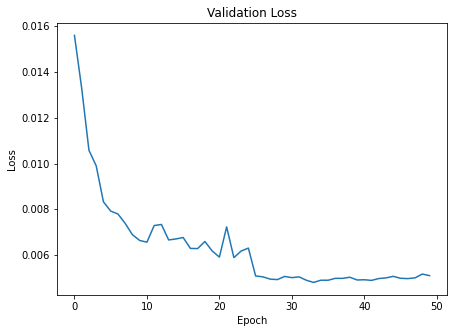

In [9]:
plot_metric(losses, 'Loss')

Plot changes in validation accuracy

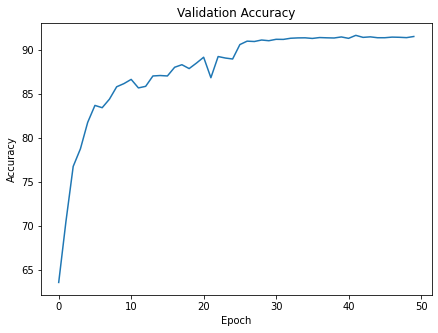

In [10]:
plot_metric(accuracies, 'Accuracy')

## Display Correct and Incorrect Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

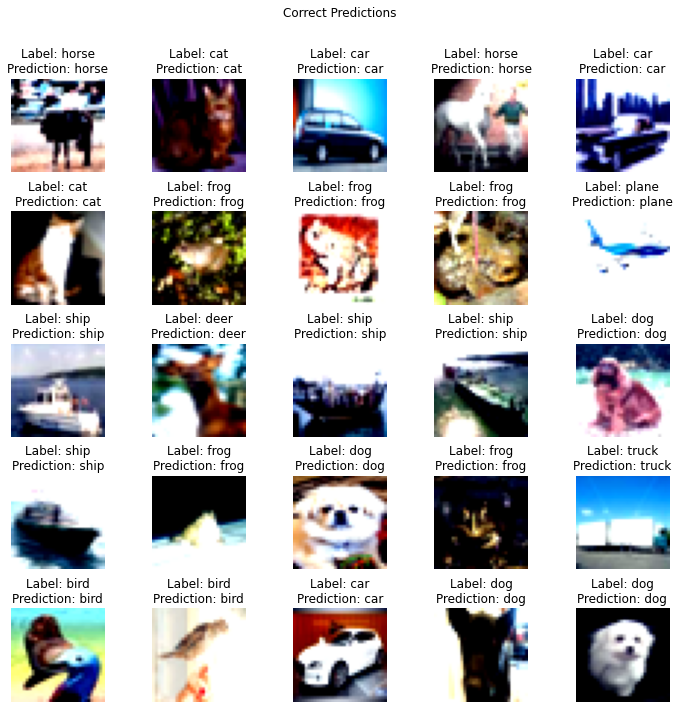

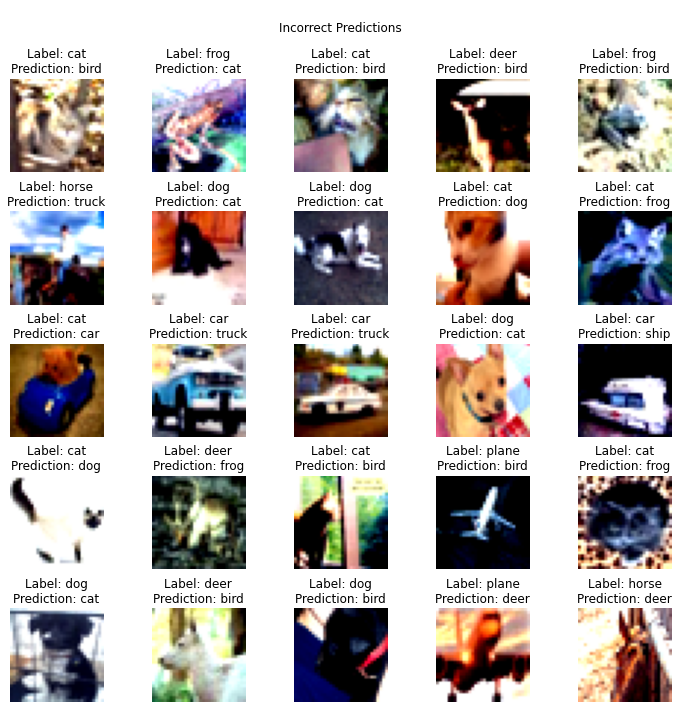

In [11]:
save_and_show_result(correct_samples, incorrect_samples, dataset.classes)

In [12]:
pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 682kB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5269 sha256=067e789d29161b0ad3698fc4787f083b547c57ef25e4d7656dcb5792eb5807d2
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


##GRADCAM Implementation

Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


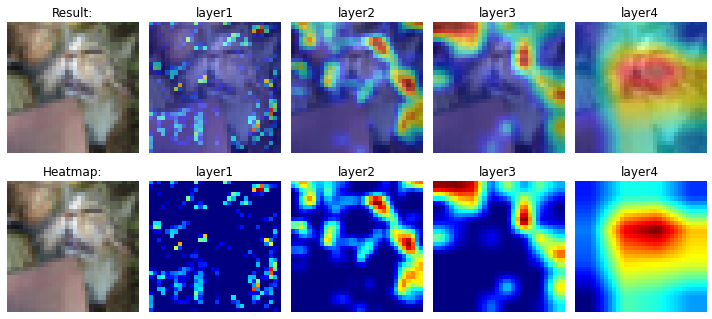

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

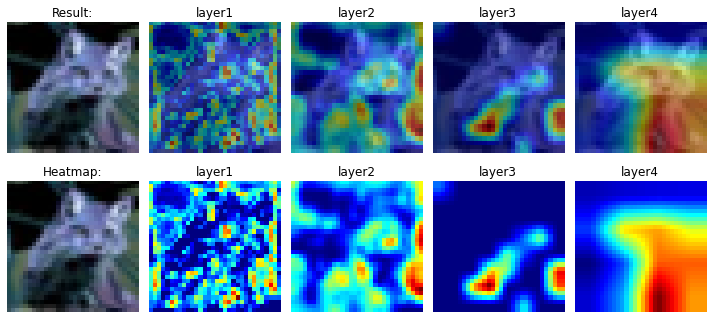

<Figure size 432x288 with 0 Axes>

In [25]:
gradcam = GradCAMView(
    model, ['layer1', 'layer2', 'layer3', 'layer4'],
    device, dataset.mean, dataset.std
)

images = [x['image'] for x in random.sample(incorrect_samples, 2)]
gradcam(images, 'gradcam')